# **CS658/458 Data Mining Final Project**
## Ehsan Mosadegh and Kendall Noraas

### Contributions


* Task 1 - 40% Ehsan, 60% Kendall
* Task 2 - 90% Ehsan, 10% Kendall
* Task 3 - 40% Ehsan, 60% Kendall





# Introduction

In this project, we applied techniques and methods that we learned from our data mining course to extract information from various datasets. 

In task 1, we were provided training data with the label information and testing data without label information. Our task was to build a model on the training data and use it to predict the labels of the testing data. We tested the effects of different methods in order to create the best model. We trained and tested four models on our dataset: decision tree, random forest, Naive Bayes Classifier and multi-layer perceptron. We explored the effects of different sizes for splitting training and validation data. Since the data for this task has significantly more feature columns than training samples, we also compressed our data into the minimum number of principle components that captures 99% percent of the variance in the trainng data and compared the performance of our models on the compressed version of the data. We found that our plots for tuning parameters were much smoother for the compressed data, but we were able to achieve the same accuracy on both datasets. 

# Literature Review

## Task 1

Some common methods for mining information from sparse data in order to perform a classification task are nearest neighbors, decision trees and rule-based classification. These are simpler methods compared to adaptive methods such as neural networks and support vector machines. Decision trees are often used in data mining, because they offer many benefits. The 

# **Task 1**

First, we import our data, which is saved in an online git repository for easy access. We also import our python libraries.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import io

import time

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import pandas as pd

! rm *training.txt*
! rm testing.txt*
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/training.txt"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/label_training.txt"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/testing.txt"

--2019-12-12 04:11:08--  https://gitlab.com/kjnoraas/dm_data/raw/master/training.txt
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7192954 (6.9M) [text/plain]
Saving to: ‘training.txt’

training.txt        100%[===================>]   6.86M  8.78MB/s    in 0.8s    

2019-12-12 04:11:10 (8.78 MB/s) - ‘training.txt’ saved [7192954/7192954]

--2019-12-12 04:11:11--  https://gitlab.com/kjnoraas/dm_data/raw/master/label_training.txt
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6185 (6.0K) [text/plain]
Saving to: ‘label_training.txt’

label_training.txt  100%[===================>]   6.04K  --.-KB/s    in 0s      

2019-12-12 04:11:12 (169 MB/s) - ‘label_training.txt’ saved [6185/6185]

--2019-12-12 04:11:13--  https://gitlab.com/

In [0]:
np_coo_matrix = np.loadtxt("training.txt")
np_label_array = np.loadtxt("label_training.txt")
test_coo = np.loadtxt("testing.txt")

Since the data is given to us in COO matrix format, we would like to preserve the sparse format to be used in our models. The following block of code saves the training data into a numpy sparse matrix.

In [0]:
from scipy.sparse import coo_matrix
import numpy as np

row = np.int64(np_coo_matrix[:,0])
col = np.int64(np_coo_matrix[:,1])
data = np.float64(np_coo_matrix[:,2])

row_test = np.int64(test_coo[:,0])
col_test = np.int64(test_coo[:,1])
data_test = np.float64(test_coo[:,2])

training_data_array = coo_matrix((data, (row, col)))
training_labels_array = np_label_array
test_set = coo_matrix((data_test, (row_test, col_test)))

print(np.shape(training_data_array), np.shape( training_labels_array), np.shape(test_set))

(1843, 26365) (1843,) (953, 26365)


# PCA (Truncated Singular Value Decomposition)

Next, we want to compress the data, since we have many more features than samples, and the feature values are very sparse, it will be hard to learn anything from the data.

In [0]:
#from sklearn.decomposition import PCA 
# NOTE: PCA does not work woth sparse matrix data format, so we use SVD approach to reduce the dimensions in the data set
from sklearn.decomposition import TruncatedSVD
# before spliting the data set, we need to apply PCA on data set to reduce the
# number of features. then, we will split the PCA-reduced data set into the
# train&valid data sets. so we will use <training_data_array> in this step.
numComponents = 10
# pca = PCA(n_components=numComponents) # create the pca with a specific number of components
# pca.fit(training_data_array) # for the data to the pca algorithm
svd = TruncatedSVD(n_components=numComponents)
svd.fit(training_data_array)
# print(svd.explained_variance_ratio_) 
transformed_data_svd = svd.transform(training_data_array)
print('transformed training data set=', transformed_data_svd.shape)
print('percentage of var explained by each component= ', svd.explained_variance_ratio_)
print('total explained var ratio=', svd.explained_variance_ratio_.sum())


transformed training data set= (1843, 10)
percentage of var explained by each component=  [0.02077294 0.02548853 0.02525974 0.02479758 0.02352009 0.02342265
 0.02298189 0.0228454  0.02233953 0.02206253]
total explained var ratio= 0.23349087438382185


In order to figure out the optimum number of principal components to compress the data into, we test up to 70 and take the smallest number that captures 99% percent of the variance in our data. 

53
[0.0, 0.020772943965106205, 0.045776334029722754, 0.0709592088627179, 0.09484003683806488, 0.11841833111852856, 0.14232180409617973, 0.16433174107250786, 0.187580154030159, 0.2116307833010314, 0.2332789222392223, 0.2573328401749042, 0.2773120783456722, 0.30139248056017054, 0.32023835382309684, 0.34211368952978083, 0.3636014677821002, 0.38555259603288755, 0.4062618900154, 0.4275923642818328, 0.4481534326839515, 0.4680734178931036, 0.48854359736458897, 0.5094419129607519, 0.5280561628890608, 0.5474245694347329, 0.5677544367001567, 0.5855339096221501, 0.6060039508496883, 0.6232104619873934, 0.6424228995327307, 0.6607517901142607, 0.6789088588313862, 0.6966971290114031, 0.7151241786148531, 0.7329080606569697, 0.7494134086838591, 0.7684607204716806, 0.784708936656177, 0.801383568208088, 0.8188073691299989, 0.8354409635619848, 0.8513789223517559, 0.8671795982349413, 0.8828227455027579, 0.8980689108650279, 0.9132024966970353, 0.9282086493099948, 0.9431713818595507, 0.957532830356154, 0.971

Text(0, 0.5, 'Total Explained Variance')

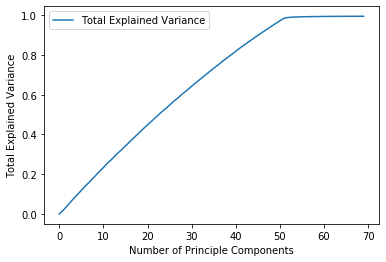

In [0]:
import matplotlib.pyplot as plt

num_components = 70

total_explained_ratio = []
svd_components = []

flag_smallest_found = False

for i in range(num_components):

  svd = TruncatedSVD(n_components=i)
  svd.fit(training_data_array)
  svd.transform(training_data_array)
  total_variance= svd.explained_variance_ratio_.sum()
  #print('total variance=', total_variance)
  total_explained_ratio.append(total_variance)
  svd_components.append(i)

  if flag_smallest_found == False:
    if total_variance > 0.99:
      print(i)
      flag_smallest_found = True

print(total_explained_ratio)
print(svd_components)

plt.plot(svd_components, total_explained_ratio)
plt.legend(['Total Explained Variance'])
plt.xlabel("Number of Principle Components")
plt.ylabel("Total Explained Variance")

# Compress Data

In the previous section, we found that 53 is the smallest number of components that captures 99% of the total variance of the data. Therefore, this is the number that we will use to compress the data.

In [0]:
optimal_num = 53

start = time.process_time()

svd = TruncatedSVD(n_components=optimal_num)
svd.fit(training_data_array)
compressed_data = svd.transform(training_data_array)

end = time.process_time()

print(compressed_data.shape)
print("Time taken to run PCA and compress data:", end - start, "s")

(1843, 53)
Time taken to run PCA and compress data: 1.8691382139999995 s


# Split Training/Validation




We wanted to test to see the effect that different training percentages has on our data mining models, so we test with 5 different training data percentages.

In [0]:
test_percentages = [10, 25, 50, 75, 90]
data = {}

for percent in test_percentages:
  trn_sz = percent/100
  data['trn_data' + str(percent)], data['vld_data' + str(percent)], \
  data['trn_lbls' + str(percent)], data['vld_lbls' + str(percent)] \
  = train_test_split(training_data_array, training_labels_array, train_size=trn_sz)

  data['c_trn_data' + str(percent)], data['c_vld_data' + str(percent)], \
  data['c_trn_lbls' + str(percent)], data['c_vld_lbls' + str(percent)] \
  = train_test_split(training_data_array, training_labels_array, train_size=trn_sz)


# Decision Tree

The first model we use is decision tree. We test the effectiveness of one single decision tree and how it changes with depth. We build decision trees of varying depth on both the uncompressed and the compressed data. 

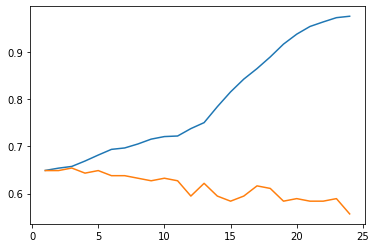

In [0]:
depths = np.arange(1, 25)
t_acc = np.zeros(len(depths))
v_acc = np.zeros(len(depths))


percent = 90
training_set_data = data['trn_data' + str(percent)]
training_set_labels = data['trn_lbls' + str(percent)]
valid_set_data = data['vld_data' + str(percent)]
valid_set_labels = data['vld_lbls' + str(percent)]

for i, depth in enumerate(depths):
  clf = tree.DecisionTreeClassifier(max_depth=depth)
  clf = clf.fit(training_set_data, training_set_labels)
  predict_train = clf.predict(training_set_data)
  predict_valid = clf.predict(valid_set_data)
  t_acc[i] = accuracy_score(training_set_labels, predict_train)
  v_acc[i] = accuracy_score(valid_set_labels, predict_valid)

plt.plot(depths, t_acc)
plt.plot(depths, v_acc)
plt.show()

## Uncompressed Data

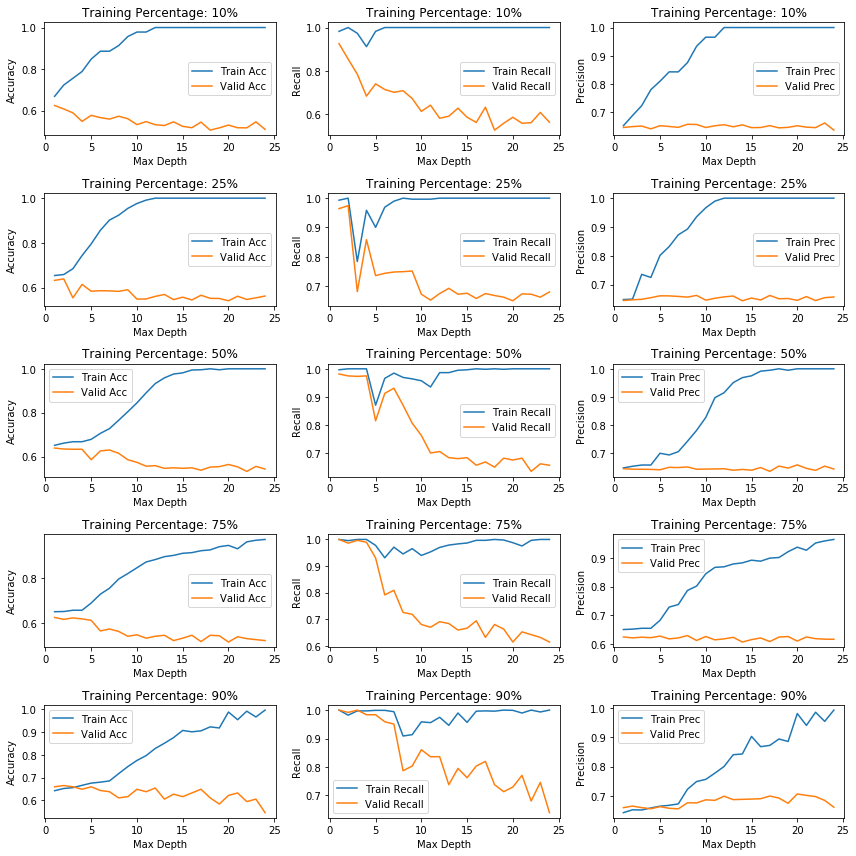

Time elapsed: 31.915546860000006 s
The maximum training accuracy achieved was 1.00 with training data percentage 10% and a max depth of 12 
The maximum validation accuracy achieved was 0.66 with training data percentage 90% and a max depth of 2 


In [0]:
max_depth_DT = np.arange(1, 25)
train_acc_DT = np.zeros(len(max_depth_DT))
valid_acc_DT = np.zeros(len(max_depth_DT))
t_recall_DT = np.zeros(len(max_depth_DT))
t_precision_DT = np.zeros(len(max_depth_DT))
v_recall_DT = np.zeros(len(max_depth_DT))
v_precision_DT = np.zeros(len(max_depth_DT))

start = time.process_time()

plt.figure(figsize=(12, 12))

max_train_accuracy = 0
max_valid_accuracy = 0
best_t_tp = 0
best_t_depth = 0
best_v_tp = 0
best_v_depth = 0

for j, percent in enumerate(test_percentages):
  for i, depth in enumerate(max_depth_DT):
    training_set_data = data['trn_data' + str(percent)]
    training_set_labels = data['trn_lbls' + str(percent)]
    valid_set_data = data['vld_data' + str(percent)]
    valid_set_labels = data['vld_lbls' + str(percent)]

    DT_clf = tree.DecisionTreeClassifier(max_depth=depth)
    DT_clf= DT_clf.fit(training_set_data, training_set_labels)
    predict_train_DT = DT_clf.predict(training_set_data)
    predict_valid_DT = DT_clf.predict(valid_set_data)
    train_acc_DT[i] = accuracy_score(training_set_labels, predict_train_DT)
    valid_acc_DT[i] = accuracy_score(valid_set_labels, predict_valid_DT)
    t_precision_DT[i], t_recall_DT[i], fscore, support = \
    precision_recall_fscore_support(training_set_labels, predict_train_DT, average='binary')
    v_precision_DT[i], v_recall_DT[i], fscore, support = \
    precision_recall_fscore_support(valid_set_labels, predict_valid_DT, average='binary')

    if train_acc_DT[i] > max_train_accuracy:
      max_train_accuracy = train_acc_DT[i]
      best_t_tp = percent
      best_t_depth = depth
    if valid_acc_DT[i] > max_valid_accuracy:
      max_valid_accuracy = valid_acc_DT[i]
      best_v_tp = percent
      best_v_depth = depth

  plt.subplot(5, 3, 3*j+1)
  plt.plot(max_depth_DT, train_acc_DT)
  plt.plot(max_depth_DT, valid_acc_DT)
  plt.title("Training Percentage: " + str(percent) + "%")
  plt.legend(['Train Acc', 'Valid Acc'])
  plt.xlabel("Max Depth")
  plt.ylabel("Accuracy")
  plt.subplot(5, 3, 3*j+2)
  plt.plot(max_depth_DT, t_recall_DT)
  plt.plot(max_depth_DT, v_recall_DT)
  plt.title("Training Percentage: " + str(percent) + "%")
  plt.legend(['Train Recall', 'Valid Recall'])
  plt.xlabel("Max Depth")
  plt.ylabel("Recall")
  plt.subplot(5, 3, 3*j+3)
  plt.plot(max_depth_DT, t_precision_DT)
  plt.plot(max_depth_DT, v_precision_DT)
  plt.title("Training Percentage: " + str(percent) + "%")
  plt.legend(['Train Prec', 'Valid Prec'])
  plt.xlabel("Max Depth")
  plt.ylabel("Precision")

plt.tight_layout()
plt.show()

end = time.process_time()
print("Time elapsed:", end - start, "s")
print(f"The maximum training accuracy achieved was {max_train_accuracy:.2f} \
with training data percentage {best_t_tp}% and a max depth of {best_t_depth} ")
print(f"The maximum validation accuracy achieved was {max_valid_accuracy:.2f} \
with training data percentage {best_v_tp}% and a max depth of {best_v_depth} ")


## Compressed Data

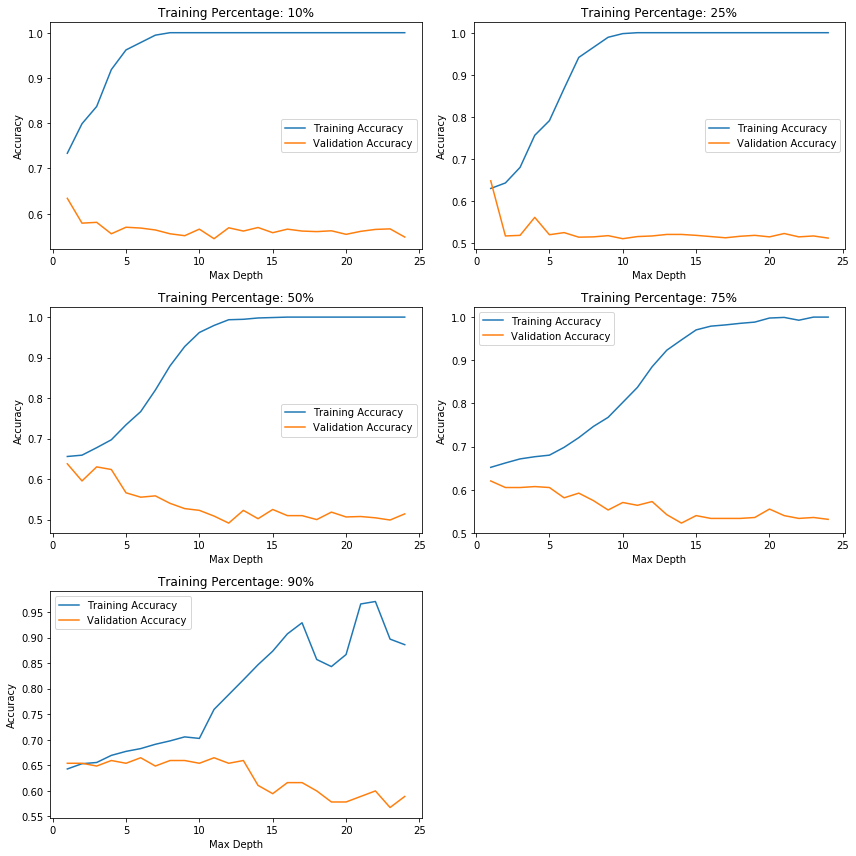

Time elapsed: 31.479658463 s
The maximum training accuracy achieved was 1.00 with training data percentage 10% and a max depth of 8 
The maximum validation accuracy achieved was 0.66 with training data percentage 90% and a max depth of 6 


In [0]:
c_max_depth_DT = np.arange(1, 25)
c_train_acc_DT = np.zeros(len(c_max_depth_DT))
c_valid_acc_DT = np.zeros(len(c_max_depth_DT))

start = time.process_time()

plt.figure(figsize=(12, 12))

max_train_accuracy = 0
max_valid_accuracy = 0
best_t_tp = 0
best_t_depth = 0
best_v_tp = 0
best_v_depth = 0

for j, percent in enumerate(test_percentages):
  for i, depth in enumerate(c_max_depth_DT):
    compressed_training_set_data = data['c_trn_data' + str(percent)]
    training_set_labels = data['c_trn_lbls' + str(percent)]
    compressed_valid_set_data = data['c_vld_data' + str(percent)]
    valid_set_labels = data['c_vld_lbls' + str(percent)]

    DT_clf = tree.DecisionTreeClassifier(max_depth=depth)
    DT_clf= DT_clf.fit(compressed_training_set_data, training_set_labels)
    predict_train_DT = DT_clf.predict(compressed_training_set_data)
    predict_valid_DT = DT_clf.predict(compressed_valid_set_data)
    c_train_acc_DT[i] = accuracy_score(training_set_labels, predict_train_DT)
    c_valid_acc_DT[i] = accuracy_score(valid_set_labels, predict_valid_DT)

    if c_train_acc_DT[i] > max_train_accuracy:
      max_train_accuracy = c_train_acc_DT[i]
      best_t_tp = percent
      best_t_depth = depth
    if c_valid_acc_DT[i] > max_valid_accuracy:
      max_valid_accuracy = c_valid_acc_DT[i]
      best_v_tp = percent
      best_v_depth = depth

  plt.subplot(3, 2, j+1)
  plt.plot(c_max_depth_DT, c_train_acc_DT)
  plt.plot(c_max_depth_DT, c_valid_acc_DT)
  plt.title("Training Percentage: " + str(percent) + "%")
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel("Max Depth")
  plt.ylabel("Accuracy")

plt.tight_layout()
plt.show() 

end = time.process_time()
print("Time elapsed:", end - start, "s")
print(f"The maximum training accuracy achieved was {max_train_accuracy:.2f} \
with training data percentage {best_t_tp}% and a max depth of {best_t_depth} ")
print(f"The maximum validation accuracy achieved was {max_valid_accuracy:.2f} \
with training data percentage {best_v_tp}% and a max depth of {best_v_depth} ")

We can see that we can acheive very high accuracy on the training data with only one decision tree. However, we see that we are overfitting to our training data by only using one tree because our accuracy on the validation data decreased.

# Random Forest

## Uncompressed Data

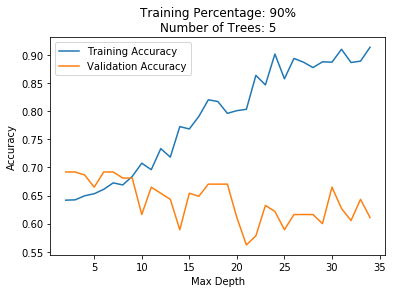

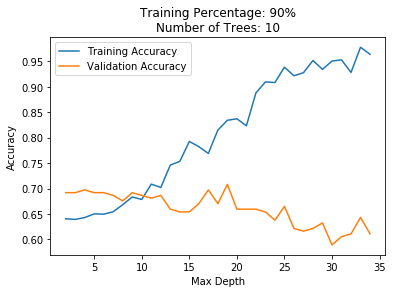

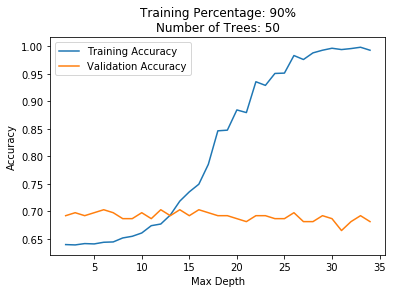

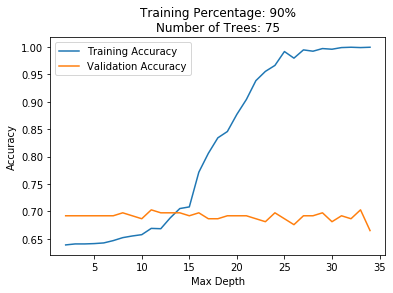

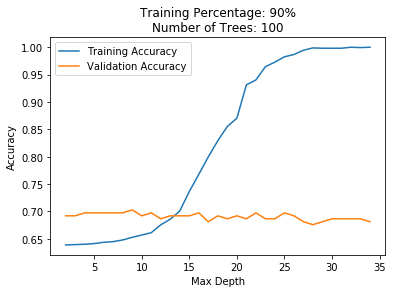

Time elapsed: 87.26621503199999 s
The maximum training accuracy achieved was 1.00 with training data percentage 90%, 100 trees and a max depth of 32 
The maximum validation accuracy achieved was 0.71 with training data percentage 90%, 10 trees and a max depth of 19 


In [0]:
max_depth_RF = np.arange(2, 35)
train_acc_RF = np.zeros(len(max_depth_RF))
valid_acc_RF = np.zeros(len(max_depth_RF))

num_trees_list = [5, 10, 50, 75, 100]
percent = 90

start = time.process_time()


max_train_accuracy = 0
max_valid_accuracy = 0
best_t_tp = 0
best_t_depth = 0
best_t_ntrees = 0
best_v_tp = 0
best_v_depth = 0
best_v_ntrees = 0

for k, num_trees in enumerate(num_trees_list):
  for i, depth in enumerate(max_depth_RF):
    training_set_data = data['trn_data' + str(percent)]
    training_set_labels = data['trn_lbls' + str(percent)]
    valid_set_data = data['vld_data' + str(percent)]
    valid_set_labels = data['vld_lbls' + str(percent)]

    RF_clf = RandomForestClassifier(n_estimators=num_trees, max_depth=depth)
    RF_clf= RF_clf.fit(training_set_data, training_set_labels)
    predict_train_RF = RF_clf.predict(training_set_data)
    predict_valid_RF = RF_clf.predict(valid_set_data)
    train_acc_RF[i] = accuracy_score(training_set_labels, predict_train_RF)
    valid_acc_RF[i] = accuracy_score(valid_set_labels, predict_valid_RF)

    if train_acc_RF[i] > max_train_accuracy:
      max_train_accuracy = train_acc_RF[i]
      best_t_tp = percent
      best_t_depth = depth
      best_t_ntrees = num_trees
    if valid_acc_RF[i] > max_valid_accuracy:
      max_valid_accuracy = valid_acc_RF[i]
      best_v_tp = percent
      best_v_depth = depth
      best_v_ntrees = num_trees

  plt.plot(max_depth_RF, train_acc_RF)
  plt.plot(max_depth_RF, valid_acc_RF)
  plt.title("Training Percentage: " + str(percent) + "%\n" + "Number of Trees: " + str(num_trees))
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel("Max Depth")
  plt.ylabel("Accuracy")
  plt.show() 

end = time.process_time()
print("Time elapsed:", end - start, "s")
print(f"The maximum training accuracy achieved was {max_train_accuracy:.2f} \
with training data percentage {best_t_tp}%, {best_t_ntrees} trees and \
a max depth of {best_t_depth} ")
print(f"The maximum validation accuracy achieved was {max_valid_accuracy:.2f} \
with training data percentage {best_v_tp}%, {best_v_ntrees} trees and \
a max depth of {best_v_depth} ")

## Compressed Data

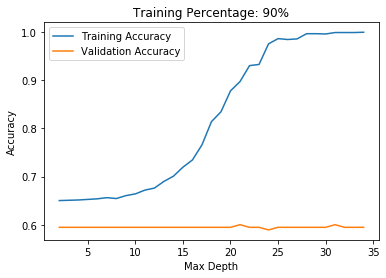

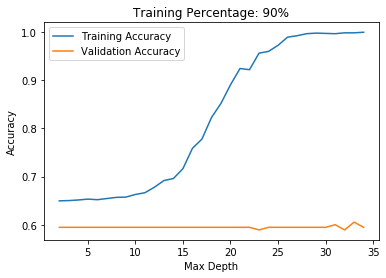

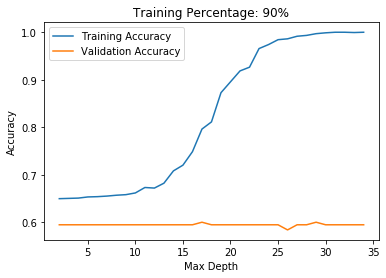

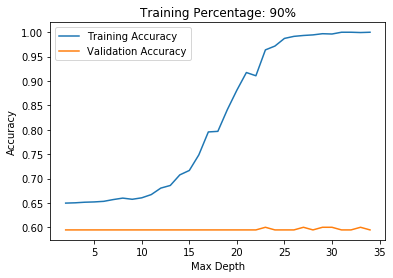

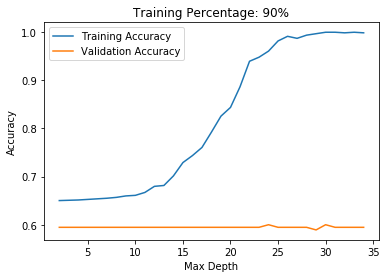

Time elapsed: 179.81925661900004 s
The maximum training accuracy achieved was 1.00 with training data percentage 90%, 5 trees and a max depth of 34 
The maximum validation accuracy achieved was 0.61 with training data percentage 90%, 10 trees and a max depth of 33 


In [0]:
max_depth_RF = np.arange(2, 35)
compressed_train_acc_RF = np.zeros(len(max_depth_RF))
compressed_valid_acc_RF = np.zeros(len(max_depth_RF))

num_trees_list = [5, 10, 50, 75, 100]
percent = 90

start = time.process_time()

max_train_accuracy = 0
max_valid_accuracy = 0
best_t_tp = 0
best_t_depth = 0
best_t_ntrees = 0
best_v_tp = 0
best_v_depth = 0
best_v_ntrees = 0

for k, num_trees in enumerate(num_trees_list):
  for i, depth in enumerate(max_depth_RF):
    compressed_training_set_data = data['c_trn_data' + str(percent)]
    training_set_labels = data['c_trn_lbls' + str(percent)]
    compressed_valid_set_data = data['c_vld_data' + str(percent)]
    valid_set_labels = data['c_vld_lbls' + str(percent)]
    
    RF_clf = RandomForestClassifier(n_estimators=100, max_depth=depth)
    RF_clf= RF_clf.fit(compressed_training_set_data, training_set_labels)
    predict_train_RF = RF_clf.predict(compressed_training_set_data)
    predict_valid_RF = RF_clf.predict(compressed_valid_set_data)
    compressed_train_acc_RF[i] = accuracy_score(training_set_labels, predict_train_RF)
    compressed_valid_acc_RF[i] = accuracy_score(valid_set_labels, predict_valid_RF)

    if compressed_train_acc_RF[i] > max_train_accuracy:
      max_train_accuracy = compressed_train_acc_RF[i]
      best_t_tp = percent
      best_t_depth = depth
      best_t_ntrees = num_trees
    if compressed_valid_acc_RF[i] > max_valid_accuracy:
      max_valid_accuracy = compressed_valid_acc_RF[i]
      best_v_tp = percent
      best_v_depth = depth
      best_v_ntrees = num_trees

  plt.plot(max_depth_RF, compressed_train_acc_RF)
  plt.plot(max_depth_RF, compressed_valid_acc_RF)
  plt.title("Training Percentage: " + str(percent) + "%")
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel("Max Depth")
  plt.ylabel("Accuracy")
  plt.show() 

end = time.process_time()
print("Time elapsed:", end - start, "s")
print(f"The maximum training accuracy achieved was {max_train_accuracy:.2f} \
with training data percentage {best_t_tp}%, {best_t_ntrees} trees and \
a max depth of {best_t_depth} ")
print(f"The maximum validation accuracy achieved was {max_valid_accuracy:.2f} \
with training data percentage {best_v_tp}%, {best_v_ntrees} trees and \
a max depth of {best_v_depth} ")

We can acheive the same high accuracy with a random forest as we can with only one decision tree. We also see that using more trees is very helpful for preventing overfitting, because our accuracy on the validation set is much higher using random forest than with just one decision tree.

# Naive Bayes

## Uncompressed

In [0]:
start = time.process_time()


for percent in test_percentages:
  training_set_data = data['trn_data' + str(percent)]
  training_set_labels = data['trn_lbls' + str(percent)]
  valid_set_data = data['vld_data' + str(percent)]
  valid_set_labels = data['vld_lbls' + str(percent)]

  gnb_clf = GaussianNB()
  gnb_clf.fit(training_set_data.toarray(), training_set_labels)
  predict_train_gnb = gnb_clf.predict(training_set_data.toarray())
  predict_valid_gnb = gnb_clf.predict(valid_set_data.toarray())
  train_acc_gnb = accuracy_score(training_set_labels, predict_train_gnb)
  valid_acc_gnb = accuracy_score(valid_set_labels, predict_valid_gnb)
  
  print("Training Percentage: " + str(percent) + "%\n\tTraining Accuracy: " + str(train_acc_gnb) + "\n\tValidation Accuracy: " + str(valid_acc_gnb))


end = time.process_time()
print(f"Time elapsed: {end - start}s")

Training Percentage: 10%
	Training Accuracy: 1.0
	Validation Accuracy: 0.567209162145871
Training Percentage: 25%
	Training Accuracy: 0.9869565217391304
	Validation Accuracy: 0.5386840202458424
Training Percentage: 50%
	Training Accuracy: 0.9630836047774158
	Validation Accuracy: 0.5780911062906724
Training Percentage: 75%
	Training Accuracy: 0.9088277858176556
	Validation Accuracy: 0.5314533622559653
Training Percentage: 90%
	Training Accuracy: 0.8956574185765983
	Validation Accuracy: 0.5027027027027027
Time elapsed: 5.105956986000024s


## Compressed

In [0]:
start = time.process_time()

for percent in test_percentages:
  compressed_training_set_data = data['c_trn_data' + str(percent)]
  training_set_labels = data['c_trn_lbls' + str(percent)]
  compressed_valid_set_data = data['c_vld_data' + str(percent)]
  valid_set_labels = data['c_vld_lbls' + str(percent)]

  gnb_clf = GaussianNB()
  gnb_clf.fit(compressed_training_set_data.toarray(), training_set_labels)
  predict_train_gnb = gnb_clf.predict(compressed_training_set_data.toarray())
  predict_valid_gnb = gnb_clf.predict(compressed_valid_set_data.toarray())
  train_acc_gnb = accuracy_score(training_set_labels, predict_train_gnb)
  valid_acc_gnb = accuracy_score(valid_set_labels, predict_valid_gnb)

  print("Training Percentage: " + str(percent) + "%\n\tTraining Accuracy: " + str(train_acc_gnb) + "\n\tValidation Accuracy: " + str(valid_acc_gnb))


end = time.process_time()
print(f"Time elapsed: {end - start}s")

Training Percentage: 10%
	Training Accuracy: 0.9945652173913043
	Validation Accuracy: 0.5840867992766727
Training Percentage: 25%
	Training Accuracy: 0.9869565217391304
	Validation Accuracy: 0.5871294287780188
Training Percentage: 50%
	Training Accuracy: 0.9457111834961998
	Validation Accuracy: 0.56941431670282
Training Percentage: 75%
	Training Accuracy: 0.9124457308248914
	Validation Accuracy: 0.5379609544468547
Training Percentage: 90%
	Training Accuracy: 0.893848009650181
	Validation Accuracy: 0.5027027027027027
Time elapsed: 4.735622342999989s


Naive Bayes does alright on the training data, but we can see that it does not generalize very well because the validation accuracy is very low.

It does very poorly on the compressed data compared to the uncompressed data.

## Multi-Layer Perceptron

# Uncompressed Data

We use 90% of the training data for training and 10% for validation to tune the parameters of our MLP. 

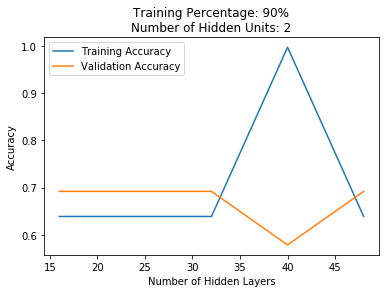

Time elapsed: 19.62415128100008 s
The maximum training accuracy achieved was 1.00 with training data percentage 90%, 40 hidden layers and 2 hidden units per layer.
The maximum validation accuracy achieved was 0.69 with training data percentage 90%, 16 hidden layers and 2 hidden units per layer.


In [0]:
#@ignore_warnings(category=ConvergenceWarning)

num_hid_units_list = [2]
num_layers_list = [16, 24, 32, 40, 48]
train_acc_mlp = np.zeros(len(num_layers_list))
valid_acc_mlp = np.zeros(len(num_layers_list))
percent = 90

max_train_accuracy = 0
max_valid_accuracy = 0
best_t_tp = 0
best_t_nlayers = 0
best_t_nunits = 0
best_v_tp = 0
best_v_nlayers = 0
best_v_nunits = 0

start = time.process_time()

#plt.figure(figsize=(12, 12))

for i, num_units in enumerate(num_hid_units_list):  
  for k, num_layers in enumerate(num_layers_list):
    training_set_data = data['trn_data' + str(percent)]
    training_set_labels = data['trn_lbls' + str(percent)]
    valid_set_data = data['vld_data' + str(percent)]
    valid_set_labels = data['vld_lbls' + str(percent)]

    mlp = MLPClassifier((num_units, num_layers))
    mlp.fit(training_set_data, training_set_labels)
    predict_train_mlp = mlp.predict(training_set_data)
    predict_valid_mlp = mlp.predict(valid_set_data)
    train_acc_mlp[k] = accuracy_score(training_set_labels, predict_train_mlp)
    valid_acc_mlp[k] = accuracy_score(valid_set_labels, predict_valid_mlp)

    if train_acc_mlp[k] > max_train_accuracy:
      max_train_accuracy = train_acc_mlp[k]
      best_t_tp = percent
      best_t_nlayers = num_layers
      best_t_nunits = num_units
    if valid_acc_mlp[k] > max_valid_accuracy:
      max_valid_accuracy = valid_acc_mlp[k]
      best_v_tp = percent
      best_v_nlayers = num_layers
      best_v_nunits = num_units

  plt.plot(num_layers_list, train_acc_mlp)
  plt.plot(num_layers_list, valid_acc_mlp)
  plt.title("Training Percentage: " + str(percent) + "%\n" + "Number of Hidden Units: " + str(num_units))
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel("Number of Hidden Layers")
  plt.ylabel("Accuracy")
  plt.show()

#plt.tight_layout()
#plt.show() 

end = time.process_time()
print("Time elapsed:", end - start, "s")
print(f"The maximum training accuracy achieved was {max_train_accuracy:.2f} \
with training data percentage {best_t_tp}%, {best_t_nlayers} hidden layers and \
{best_t_nunits} hidden units per layer.")
print(f"The maximum validation accuracy achieved was {max_valid_accuracy:.2f} \
with training data percentage {best_v_tp}%, {best_v_nlayers} hidden layers and \
{best_v_nunits} hidden units per layer.")

## Compressed Data

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


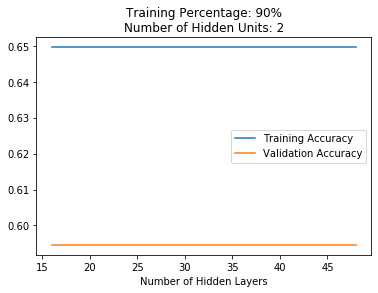

Time elapsed: 39.11163814899999 s
The maximum training accuracy achieved was 0.65 with training data percentage 90%, 16 hidden layers and 2 hidden units per layer.
The maximum validation accuracy achieved was 0.59 with training data percentage 90%, 16 hidden layers and 2 hidden units per layer.


In [0]:
#@ignore_warnings(category=ConvergenceWarning)

c_num_hid_units_list = [2, 4, 8, 16]
c_num_layers_list = [2,4, 8, 16, 32]
c_train_acc_mlp = np.zeros(len(num_layers_list))
c_valid_acc_mlp = np.zeros(len(num_layers_list))

max_train_accuracy = 0
max_valid_accuracy = 0
best_t_tp = 0
best_t_nlayers = 0
best_t_nunits = 0
best_v_tp = 0
best_v_nlayers = 0
best_v_nunits = 0

start = time.process_time()

for i, num_units in enumerate(num_hid_units_list):  
  for k, num_layers in enumerate(num_layers_list):
    compressed_training_set_data = data['c_trn_data' + str(percent)]
    training_set_labels = data['c_trn_lbls' + str(percent)]
    compressed_valid_set_data = data['c_vld_data' + str(percent)]
    valid_set_labels = data['c_vld_lbls' + str(percent)]
    
    c_mlp = MLPClassifier((num_units))
    c_mlp.fit(compressed_training_set_data, training_set_labels)
    predict_train_mlp = mlp.predict(compressed_training_set_data)
    predict_valid_mlp = mlp.predict(compressed_valid_set_data)
    c_train_acc_mlp[k] = accuracy_score(training_set_labels, predict_train_mlp)
    c_valid_acc_mlp[k] = accuracy_score(valid_set_labels, predict_valid_mlp)

    if c_train_acc_mlp[k] > max_train_accuracy:
      max_train_accuracy = c_train_acc_mlp[k]
      best_t_tp = percent
      best_t_nlayers = num_layers
      best_t_nunits = num_units
    if c_valid_acc_mlp[k] > max_valid_accuracy:
      max_valid_accuracy = c_valid_acc_mlp[k]
      best_v_tp = percent
      best_v_nlayers = num_layers
      best_v_nunits = num_units

  plt.plot(num_layers_list, c_train_acc_mlp)
  plt.plot(num_layers_list, c_valid_acc_mlp)
  plt.title("Training Percentage: " + str(percent) + "%\n" + "Number of Hidden Units: " + str(num_units))
  plt.legend(['Training Accuracy', 'Validation Accuracy'])
  plt.xlabel("Number of Hidden Layers")
  plt.show()


end = time.process_time()
print("Time elapsed:", end - start, "s")
print(f"The maximum training accuracy achieved was {max_train_accuracy:.2f} \
with training data percentage {best_t_tp}%, {best_t_nlayers} hidden layers and \
{best_t_nunits} hidden units per layer.")
print(f"The maximum validation accuracy achieved was {max_valid_accuracy:.2f} \
with training data percentage {best_v_tp}%, {best_v_nlayers} hidden layers and \
{best_v_nunits} hidden units per layer.")

Our results for the MLP varied wildly with the splitting of training/validation data and we decided not to use it because the results were not consistent. 

## Predict Testing Labels

We use a random forest model with 100 hundred trees of depth 3 trained on 100% of the uncompressed dataset to predict the labels for our test set.

In [0]:
test_clf = RandomForestClassifier(n_estimators=100, max_depth=32)
test_clf= test_clf.fit(training_data_array, training_labels_array)
predict_train_RF = test_clf.predict(training_data_array)
train_acc_test_clf = accuracy_score(training_labels_array, predict_train_RF)

print(f"Training Accuracy: {train_acc_test_clf}")

predict_test_labels = test_clf.predict(test_set)
print(predict_test_labels)


Training Accuracy: 0.9989148128052089
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1. 

In [0]:
! rm -R drive/'My Drive'/Documents/College/'Fall 2019'/CS458/project/output
! mkdir drive/'My Drive'/Documents/College/'Fall 2019'/CS458/project/output
! touch drive/'My Drive'/Documents/College/'Fall 2019'/CS458/project/output/predicted_test_labels.txt 
! ls drive/'My Drive'/Documents/College/'Fall 2019'/CS458/project/output


print('Logging to file...')
start = time.process_time()
for item in predict_test_labels:
  label = str(int(item))+' '
  #print(label)
  ! echo $label >> drive/'My Drive'/Documents/College/'Fall 2019'/CS458/project/output/predicted_test_labels.txt

end = time.process_time()
duration = end - start
print(f'Done!\nTime Elapsed: {duration}')

predicted_test_labels.txt
Logging to file...
Done!
Time Elapsed: 21.795822191s


# **Task 2**


## Introduction

We did literature review about how to estimate wind speed from some mathematical functions to fill the Nan values in dataset.

Task 2

The goal of thsi task was to predict the wind speed at a favorable monitoring site with relation to other neighbor monitoring sites. The sensor dataset had missing values and we replaced the NaN data by using a mathematical function that was cited in literature.


In [5]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas import DataFrame as df
import os
import matplotlib.pyplot as plt

import io

import time

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import pandas as pd

! rm *.csv*
! rm *.txt*

! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/E_Saltdesert.csv"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/E_Sagebrush.csv"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/W_Subalpine.csv"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/W_Montana.csv"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/W_Pinyon.csv"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/W_Sagebrush.csv"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/test_master_file_2019-06-01_rundays_30.txt"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/master_file_2019-06-01_rundays_30.txt"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/master_file_2019-05-01_rundays_30.txt"
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/master_dataset_2019-4-1_rundays_1_test.txt"

--2019-12-13 07:12:25--  https://gitlab.com/kjnoraas/dm_data/raw/master/E_Saltdesert.csv
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2108050 (2.0M) [text/plain]
Saving to: ‘E_Saltdesert.csv’

E_Saltdesert.csv    100%[===================>]   2.01M  3.02MB/s    in 0.7s    

2019-12-13 07:12:26 (3.02 MB/s) - ‘E_Saltdesert.csv’ saved [2108050/2108050]

--2019-12-13 07:12:27--  https://gitlab.com/kjnoraas/dm_data/raw/master/E_Sagebrush.csv
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2048024 (2.0M) [text/plain]
Saving to: ‘E_Sagebrush.csv’

E_Sagebrush.csv     100%[===================>]   1.95M  3.42MB/s    in 0.6s    

2019-12-13 07:12:29 (3.42 MB/s) - ‘E_Sagebrush.csv’ saved [2048024/2048024]

--2019-12-13 07:12:30--  https:

In [0]:
! ls

E_Sagebrush.csv
E_Saltdesert.csv
master_dataset_2019-4-1_rundays_1_test.txt
master_file_2019-05-01_rundays_30.txt
master_file_2019-06-01_rundays_30.txt
sample_data
test_master_file_2019-06-01_rundays_30.txt
W_Montana.csv
W_Pinyon.csv
W_Sagebrush.csv
W_Subalpine.csv


## Pre-processing step 1: Visual Inspection
First, we inspected the data sets visually to explore the data and check if there was any missing values inside the data. Based on the literature, we picked the time period of moinths 5-6 that the wind speed was highets and also had the least missing values.





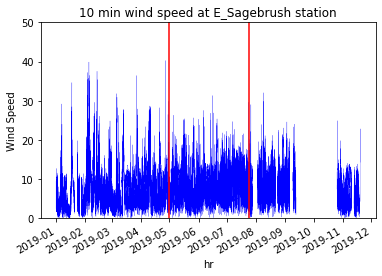

In [0]:
#input_file = 'E_Subalpaine.csv' # no wind data

station_list=['E_Saltdesert.csv', 'E_Sagebrush.csv', 'W_Subalpine.csv', 'W_Montana.csv', 'W_Pinyon.csv', 'W_Sagebrush.csv']
stn = station_list[1]

data = pd.read_csv(stn, skiprows=9, names=['date','wind_speed'], parse_dates=['date']) # skip the first 10 rows with header info
X = data['date']
Y = data['wind_speed']
plt.plot(X, Y, color='b', linewidth=0.2)
plt.xlabel('hr')
plt.ylabel('Wind Speed')
plt.title('10 min wind speed at %s station' %stn[:-4])
plt.axvline(x='2019-05-01T00', color='red')
plt.axvline(x='2019-07-25T00', color='red')

plt.ylim(0, 50)
plt.gcf().autofmt_xdate()


    # ax = plt.subplot(3, 3, stn + 1)
    # ax = data.plot(X, Y)
    # fig, ax = plt.subplots()
    # ax.plot(X,Y)
    # ax.set_xlabel('hr/day')
    # ax.set_ylabel('wind speed')
    # ax.set_title(station_list[stn][:-4])

#plt.savefig(os.path.join('./my_images/')+stn[:-4]+".png")
#plt.show()

## Pre-processing step 2: Data Cleaning

This step receives each station file as input and loops through each file. First we set a time period at the top of the script and define the number of the days and the month to start and the script will process each sensor file and extract a time period from the dataset and will append it to a master dataset.
This step would take a long time to finish, so we ran the script on our local machine and wrote the processed data into a file. We ran this script for each month seperately and created a master dataframe for each month. Then we uploaded each dataset to this colab workspace. Each master dataset is an input for the next steps of this taks. This script by default is set up to produce a master dataset for 1 day (days_from_start=1) that starts from mon=1 and day=1 as a test.

In [0]:
# time period setting
days_from_start = 1 # days will convert to hrs

###########################################################################
# build the data time ruler- start from a desired datetime

# we need to have a dt period. we are going to extract the following period from the dataset.
yr = 2019
mon = 1
day = 1
# number of 10-min intervals in an hour- range: 1-6 intervals in an hour
minunte_intervals_in_hr = 6 # intervals

# define start and end datetime
datetime_start = dt.datetime(yr, mon, day, 0, 0, 0)
datetime_end = datetime_start + dt.timedelta(days=days_from_start)
print('-> running for period of %s days starting from: %s-%s-%s' % (days_from_start,yr,mon,day))
print('-> start date is: %s' % str(datetime_start))
print('-> interval period in an hour: every %s min' % (60/minunte_intervals_in_hr))
# define the period in no of 10min steps
no_10mins_steps_in_period = (datetime_end - datetime_start).days*24*minunte_intervals_in_hr # change to each 10 min to make the period; days*24hrs*6observations per hr
# make number of time steps
no_10mins_steps_in_period = int(no_10mins_steps_in_period)
# create a np array for our ruler, fill it with nan
dt_ruler = np.full([no_10mins_steps_in_period + 1], np.nan, dtype='object')
# define a new var to use in loop
dt_at_10min_interval = datetime_start
# create a list of date-time objects from 10min steps as a ruler for our dataset; then fill it
for step in range(no_10mins_steps_in_period):
    # period_dt_list[step]
    dt_at_10min_interval = dt_at_10min_interval + dt.timedelta(minutes=10) # increment every 10min
    dt_ruler[step] = dt_at_10min_interval # fill the ruler with dt at 10min interval
print('-> shape of datetime ruler is: %s' %dt_ruler.shape)

###########################################################################
# we need to create a master dataset, open each station dataset, and fill the master dataset with sensor
# values at each observation timestep.  we have the ruler and we use it as the index of the the master dataset.

# define list of stations
station_list = ['E_Sagebrush.csv', 'E_Saltdesert.csv', 'W_Subalpine.csv', 'W_Montana.csv', 'W_Pinyon.csv', 'W_Sagebrush.csv']
print('-> no. of stations included in this processing step: %s' % len(station_list))
# list comprehension to use as the col of dataframe
col_list = [i[:-4] for i in station_list]

# create a np array as master dataset to store data; master data set= mds
master_ds_rows = dt_ruler.shape[0] # use ruler to make the ds index
master_ds_cols = len(station_list)
# create a master dataset
master_array = np.full([master_ds_rows, master_ds_cols], np.nan, dtype='float') # how create the mds array?
#print(master_array)

# iterate over each station list and read data to the master dataset
for stn_no, stn_name in enumerate(station_list):
    print('-> for stn no.: %s, %s' % (stn_no, stn_name))
    # read each csv file and load it into dataframe
    # note the format: <yyyy-MM-dd'T'HH:mm:ss.SSS'Z'> Z=timezone offset data, this is a challenge
    stn_dataset = pd.read_csv(stn_name, skiprows=9, names=['datetime', 'wind_speed'], parse_dates=['datetime']) # skip the first 10 rows with header info
    # stn_dataset['dt'] = stn_dataset['dt'].dt.tz_localize(timezone.utc)

    # check if datetime col is ware or naive
    stn_dt_sample = stn_dataset['datetime'][0]
    print('-> sample moment from stn dataset: %s' % stn_dt_sample)
    # if the output of bellow does not return None,
    ## datetime is aware= the moment knows about timezone by its UTC offset, else it's naive= localized
    ## our datetime shows time in utc timezone, i.e. it has offset from UTC time
    # print('-> check for yzinfo: %s' %stn_dt_sample.tzinfo)  # if None= no localization needed, else datetime object is sware
    # print('-> check for offset: %s' %stn_dt_sample.tzinfo.utcoffset(stn_dt_sample))  # datetime object is sware
    #naive_local_dt = stn_dt_sample.replace(tzinfo=None)
    #local_offset_dt = stn_dt_sample.utcoffset()
    #print('-> now convert to local')
    # stn_dt_sample.dt.tz_convert(tz=None)

    # update dataset == convert datetime column from UTC-offset to local time
    stn_dataset['datetime'] = stn_dataset['datetime'].dt.tz_convert(tz=None)

    # pick one datetime from ruler and compare against sensor data
    for step_ruler, ruler_dt_stamp in enumerate(dt_ruler):
        # pick each dt from stn dataset
        for stn_dt_step in range(len(stn_dataset['datetime'])):
            # check if datetime matches- Q-how compare dt? str or dt itself? how localize dt?
            stn_dt_stamp = stn_dataset['datetime'][stn_dt_step]

            if ruler_dt_stamp == stn_dt_stamp:
                # print('-> both agree for:')
                # print('ruler: %s' %ruler_dt_stamp)
                # print('  stn: %s' %stn_dt_stamp)

                # extract value from stn dataset and put it in the master array
                extracted_val = stn_dataset['wind_speed'][stn_dt_step]
                #print('-> found for stn no: %s at moment %s' %(stn_no, ruler_dt_stamp))
                master_array[step_ruler, stn_no] = extracted_val    # change it to col numbers later
                continue    # to next dt in stn dataset

            # else:
            #     #print('-> did not find dt match between: %s and %s' %(ruler_dt_stamp, stn_dt_stamp))
            #     # fill the row with nan at the same spot
            #     master_ds_array[step_ruler, stn_no] = '-999'
# print('step of ruler: %s' % step_ruler)
# no_of_days = (step_ruler/144)
# print('no of days: %s' % no_of_days)

# create a data-frame from np array for each month
master_df_with_nan = df(data=master_array, index=dt_ruler, columns=col_list)
print('-> the head of master dataset:\n %s' % master_df_with_nan.head())
print('-> the shape of master dataset: %s' % str(master_df_with_nan.shape))

# this section is for writing the data to a machine. Since we are running thsi example on colab,
# we do not write any file into the machine

# # define path and file name to write the data to a csv file
# master_file_name = ('master_dataset_%s-%s-%s_rundays_%s.txt' % (str(yr),str(mon),str(day),str(days_from_start)))
# # print('-> output file is: %s' % master_file_name)
# # master_file_path = '/Users/ehsanmos/Documents/CS_courses_UNR/Fall2019/Data_mining/Data_mining_projects/final_projects/task_2/datasets/'
# master_file_path = os.getcwd()
# # write the new formed dataset in to a csv file at desired location
# master_df.to_csv(os.path.join(master_file_path, master_file_name), index_label='date')
# ###########################################################################


-> running for period of 1 days starting from: 2019-1-1
-> start date is: 2019-01-01 00:00:00
-> interval period in an hour: every 10.0 min
-> shape of datetime ruler is: 145
-> no. of stations included in this processing step: 6
-> for stn no.: 0, E_Sagebrush.csv
-> sample moment from stn dataset: 2019-01-01 00:00:00-08:00
-> for stn no.: 1, E_Saltdesert.csv
-> sample moment from stn dataset: 2019-01-01 00:00:00-08:00
-> for stn no.: 2, W_Subalpine.csv
-> sample moment from stn dataset: 2019-01-01 00:00:00-08:00
-> for stn no.: 3, W_Montana.csv
-> sample moment from stn dataset: 2019-01-01 00:00:00-08:00
-> for stn no.: 4, W_Pinyon.csv
-> sample moment from stn dataset: 2019-01-01 00:00:00-08:00
-> for stn no.: 5, W_Sagebrush.csv
-> sample moment from stn dataset: 2019-01-01 00:00:00-08:00
-> the head of master dataset:
                      E_Sagebrush  E_Saltdesert  ...  W_Pinyon  W_Sagebrush
2019-01-01 00:10:00          NaN           NaN  ...       NaN          NaN
2019-01-01 00:20

## Pre-processing step3: Missing Value Estimation


We used a function to fill the nan values. This function calculates the diurnal pattern of wind speed and estimates the hourly wind speed from mean of the diurnal wind profile at each monitopring site.

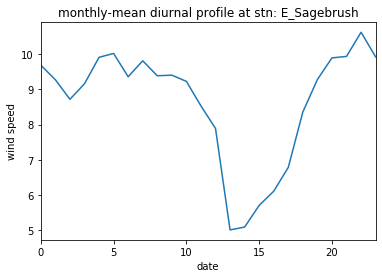

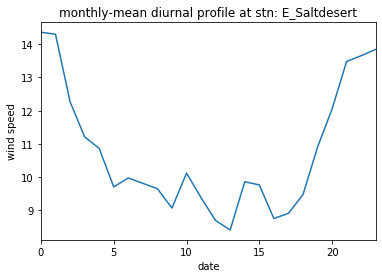

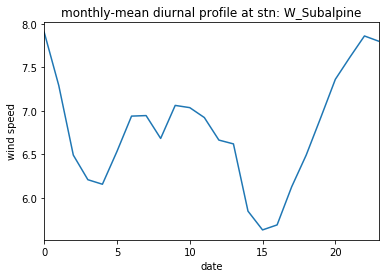

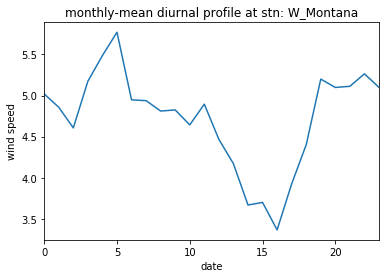

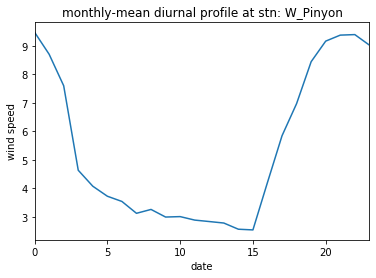

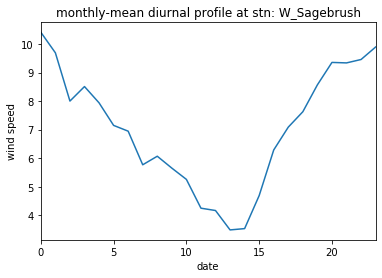

In [14]:
# monthly-mean diurnal plots of wind speed
# the whole process here should convert master_df_with_nan to master_df_nan_filled
master_file = 'master_file_2019-06-01_rundays_30.txt'
master_df = pd.read_csv(master_file)
#master_df_with_nan = master_df.set_index('date', drop=False) # key=col name
master_df['date'] = pd.to_datetime(master_df['date'])
master_df_with_nan = master_df.set_index('date', drop=True) # key=col name


stn_name_list = [i for i in master_df_with_nan.columns]
stn_ws_average = []
ws_diurnal_val = []

# calculate monthly mean WS diurnal plots
# select columns of dataframe inside loop
for col_step in range(len(master_df_with_nan.columns)):
    # select each column
    df_one_col = master_df_with_nan.iloc[:,col_step]
    # hrly_list = df_one_col.groupby(master_df_with_nan.index.hour).mean()
    #diurnal_group = df_one_col.groupby([master_df_with_nan.index.hour, master_df_with_nan.index.minute]).mean()
    diurnal_group = df_one_col.groupby(master_df_with_nan.index.hour).mean()
    # take the average of the diurnal profile
    stn_ws_average.append(diurnal_group.mean())
    # save the diurnal values
    ws_diurnal_val.append(diurnal_group)
    plt.title('monthly-mean diurnal profile at stn: %s' % stn_name_list[col_step])
    plt.ylabel('wind speed')
    plt.xlabel('hour of day')

    diurnal_group.plot()
    plt.show()

from the plots above, we estimate the peak of the day is at hour=20 and we use this in our calculations

In [0]:
# define function to estimate hourly wind speed
def ws_nan_estimate(stn_mean_ws, hr_of_day):
    theta=0.3 # from literature
    hr_of_peak_ws = 20
    ws_hrly_estimated = stn_mean_ws * (1 + (theta * np.cos(((2 * np.pi) / 24) * (hr_of_day - hr_of_peak_ws))))

    return ws_hrly_estimated
# the function returns the following list
#ws_diurnal_cycle_list = []

from the visual inspection we used the information and replaced NaN in our dataset with estimated values

In [22]:
# loop to iterate over all columns to find out if we have nan in dataset
for stn_step, stn_name in enumerate(stn_name_list): #master_df_with_nan.columns.to_list()):
    print('-> processing stn no. %s and name %s' % (stn_step, stn_name))

    condition = master_df_with_nan.iloc[:, stn_step].isnull()
    # index = np.where(condition)[0]     # returns original index
    # find the datetime index of the rows with nan values in a list, if any
    nan_index_list = master_df_with_nan.loc[condition].index.to_list()
    print('-> found %s dt/rows with NaN:\n%s' % (len(nan_index_list), nan_index_list))
    # if the index list does not have any nan values then go to next iteration==station
    if (len(nan_index_list) == 0):
        print('-> did NOt find any NaN for stn: %s, going to next stn!' % stn_name)
        continue

    # will fill this list later from a WS function
    ws_diurnal_cycle_list = [i for i in range(0, 24, 1)]

    # we pick each dt with nan and find the estimated value for it
    for nan_dt_row in nan_index_list:
        # # change str to dt
        # dt_obj = dt.datetime.strptime(nan_dt_row, '%Y-%m-%d %H:%M:%S')

        # only extract the hr from dt
        hr_of_day = nan_dt_row.hour
        #print(hr_of_day)

        # here we use the list from the function
        # find the suitable value from the estimated list
        # ws_estimated = ws_diurnal_cycle_list[hr_of_day]

        stn_mean_ws = stn_ws_average[stn_step]
        ws_estimated = ws_nan_estimate(stn_mean_ws, hr_of_day)
        #print('-> nan replaced with: %s' % ws_estimated)

        # update NaN with estimated value
        master_df_with_nan.loc[nan_dt_row, stn_name] = ws_estimated

print(master_df_with_nan.head())
# the master_df_with_nan is updated inside the loop above
# we need the nan_filld master df for next step which is the regression
master_df_nan_filled = master_df_with_nan.copy()

-> processing stn no. 0 and name E_Sagebrush
-> found 0 dt/rows with NaN:
[]
-> did NOt find any NaN for stn: E_Sagebrush, going to next stn!
-> processing stn no. 1 and name E_Saltdesert
-> found 0 dt/rows with NaN:
[]
-> did NOt find any NaN for stn: E_Saltdesert, going to next stn!
-> processing stn no. 2 and name W_Subalpine
-> found 0 dt/rows with NaN:
[]
-> did NOt find any NaN for stn: W_Subalpine, going to next stn!
-> processing stn no. 3 and name W_Montana
-> found 0 dt/rows with NaN:
[]
-> did NOt find any NaN for stn: W_Montana, going to next stn!
-> processing stn no. 4 and name W_Pinyon
-> found 0 dt/rows with NaN:
[]
-> did NOt find any NaN for stn: W_Pinyon, going to next stn!
-> processing stn no. 5 and name W_Sagebrush
-> found 0 dt/rows with NaN:
[]
-> did NOt find any NaN for stn: W_Sagebrush, going to next stn!
                     E_Sagebrush  E_Saltdesert  ...  W_Pinyon  W_Sagebrush
date                                            ...                       
2019-0

## Regression as Prediction

we use the updated df (with no nan) from previous step here. We made predictions for the site E_Sagebrush with considering wind speed values from other neighbor sites.

In [0]:
#from sklearn import linear_model
#from sklearn.linear_model import Perceptron
#df_test = pd.read_csv('test_master_file_2019-06-01_rundays_30.txt', header=0)
#master_df_nan_filled
#df_test.dropna(axis='rows', how='any', inplace=True)
#print(df_test.head())
Y = master_df_nan_filled['E_Sagebrush']
X = master_df_nan_filled.drop(['E_Sagebrush'], axis='columns')
#print(X.head)
#print(Y.head)
#class_obj = linear_model.Perceptron()

In [20]:
trn_sz = 0.9

X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=trn_sz)

print(X_train.shape)
print(X_valid.shape)
print(Y_train.shape)
print(Y_valid.shape)

(3888, 5)
(432, 5)
(3888,)
(432,)


now apply the algorithm on data

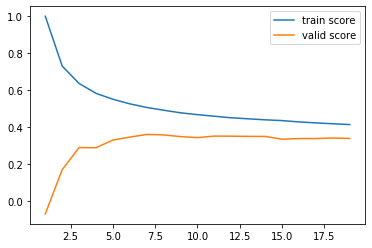

In [21]:
from sklearn.neighbors import KNeighborsRegressor as KNN

k_list = np.arange(1,20)
train_accuracy = np.zeros(len(k_list))
valid_accuracy = np.zeros(len(k_list))

for step, k_value in enumerate(k_list):
  neighbor = KNN(n_neighbors=k_value)
  neighbor.fit(X_train, Y_train)
  training_predictions = neighbor.predict(X_train)
  validation_predictions = neighbor.predict(X_valid)
  training_score = neighbor.score(X_train, Y_train)
  validation_score = neighbor.score(X_valid, Y_valid)

  train_accuracy[step] = training_score
  valid_accuracy[step] = validation_score

plt.plot(k_list, train_accuracy, label='train score')
plt.plot(k_list, valid_accuracy, label='valid score')
plt.legend()
plt.show()



Ehsan - talk about the plot and score values

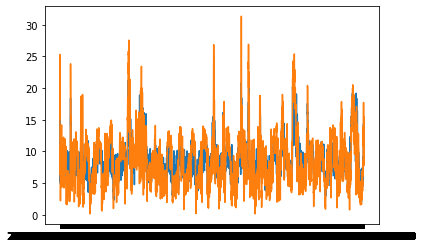

In [0]:
k_optimum = 5
neighbor = KNN(n_neighbors=k_optimum)
neighbor.fit(X, Y)

training_predictions = neighbor.predict(X)
training_score = neighbor.score(X, Y)

timestamps = df_test['date']
plt.plot(timestamps, training_predictions)
plt.plot(timestamps, Y)
plt.show()

talk about the results

# **Task 3**

In [0]:
! rm *.csv
! wget "https://gitlab.com/kjnoraas/dm_data/raw/master/UsedAutoRELEVATEfirst10000-noLatLong.csv"

--2019-12-11 06:39:19--  https://gitlab.com/kjnoraas/dm_data/raw/master/UsedAutoRELEVATEfirst10000-noLatLong.csv
Resolving gitlab.com (gitlab.com)... 35.231.145.151
Connecting to gitlab.com (gitlab.com)|35.231.145.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8679965 (8.3M) [text/plain]
Saving to: ‘UsedAutoRELEVATEfirst10000-noLatLong.csv’

UsedAutoRELEVATEfir 100%[===================>]   8.28M  13.6MB/s    in 0.6s    

2019-12-11 06:39:21 (13.6 MB/s) - ‘UsedAutoRELEVATEfirst10000-noLatLong.csv’ saved [8679965/8679965]



In [0]:
import pandas as pd
import io

car_df = pd.read_csv("UsedAutoRELEVATEfirst10000-noLatLong.csv", header=0, low_memory=False)

print(car_df)


                                           Customer_Link  ...  Census 2010: Tract and block group
0                                                    NaN  ...                                 NaN
1      XY6311iHZIZPD_yA204uROLkMVig1_kLPrrJuCiESR5tnC-yI  ...                           6945001.0
2                                                    NaN  ...                                 NaN
3      XY6311rueXSb2PoB99IvW5wuBoN3T-WYHPXKkzgTt9qCqGAVw  ...                                 NaN
4                                                    NaN  ...                                 NaN
...                                                  ...  ...                                 ...
19993  XY6311kHfrDbjqwKN5zdrA6R3FPPuJaWIAeHCAgzEaFDN799I  ...                            129021.0
19994                                                NaN  ...                                 NaN
19995  XY6311GLYX8r2hDOfp_2bpJiAmPajZlQ6Z1FkSLk4klJkqRPY  ...                                 NaN
19996               

## Remove Unnecessary Rows and Columns

In [0]:
car_df.dropna(axis='columns', how='all', inplace=True)
car_df.dropna(axis='rows', how='all', inplace=True)
#car_df.drop('Customer_Link', axis='columns', inplace=True)
#print(car_df)
#print(car_df['Vehicle Type'])

na_col_thresh = 5000 # keep only the columns that have at least thresh non-NAN values

# drop columns that are more than half full of NaN
car_df.dropna(axis='columns', how='any', thresh=na_col_thresh)

#for col in car_df.columns:
  #print(col)

#car_df.dropna(axis='rows', how='any', subset=['Model 1', 'Vehicle Type', 'Make 1'])  # doesn't do anything


#corr = df.corr()
#corr.style.background_gradient(cmap='coolwarm')
#data_headers=list(car_df)
#print(data_headers)
#car_matrix = car_df.to_numpy()
#print(car_matrix.shape)




Customer_Link  ...  Census 2010: Tract and block group
1      XY6311iHZIZPD_yA204uROLkMVig1_kLPrrJuCiESR5tnC-yI  ...                           6945001.0
3      XY6311rueXSb2PoB99IvW5wuBoN3T-WYHPXKkzgTt9qCqGAVw  ...                                 NaN
5                                              UNMATCHED  ...                                 NaN
7      XY6311DlM7DYe-sKJQDUcYsB5tzw06o6tOuSISzhrTzIkg-q4  ...                             80001.0
9      XY6311mKnDv9rrKvsdj9pAFXNlWzGmqZccDrAr0uAdwRHFAcE  ...                                 NaN
...                                                  ...  ...                                 ...
19989  XY6311ys4GQM7fyJU-WzHV30i2pqkroqVMxKt5DZH-Qh53HL4  ...                                 NaN
19991  XY6311Alkm2vldnr1YK7bcgAerGGUeD23jaMxu6kCwn8H7hZ0  ...                                 NaN
19993  XY6311kHfrDbjqwKN5zdrA6R3FPPuJaWIAeHCAgzEaFDN799I  ...                            129021.0
19995  XY6311GLYX8r2hDOfp_2bpJiAmPajZlQ6Z1FkSLk4klJkqRPY  ...                                 NaN
19997  XY6311lLTW2rauX-M5PJrtLPqdTbckAAsJa38NR-BPmz5CMCE  ...                                 NaN

[9999 rows x 207 columns]

In [0]:
#drop previous index column and reset
car_df.reset_index(drop=True, inplace=True)

In [0]:
import numpy as np

headers = list(car_df)

to_drop = np.array([])

num_unique = car_df.nunique(axis='columns', dropna=False)
for num in num_unique:
  print(num)



PCA is not recommended to be used with catergorical feature values, so we train random forests and neural networks with the entire dataset.


## Random Forest
### Predict Vehicle Type

In [0]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

max_depth_RF = np.arange(2, 30)
train_acc_RF = np.zeros(len(max_depth_RF))

dataVT = pd.get_dummies(car_df.drop('Vehicle Type', axis='columns')).fillna(0)
labelsVT = pd.get_dummies(car_df['Vehicle Type']).fillna(0)

for i, depth in enumerate(max_depth_RF):
  print(depth)
  RF_clf = RandomForestClassifier(n_estimators=100, max_depth=depth)
  RF_clf= RF_clf.fit(dataVT, labelsVT)
  predictVT = RF_clf.predict(dataVT)
  train_acc_RF[i] = accuracy_score(labelsVT, predictVT)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


Text(0, 0.5, 'Accuracy')

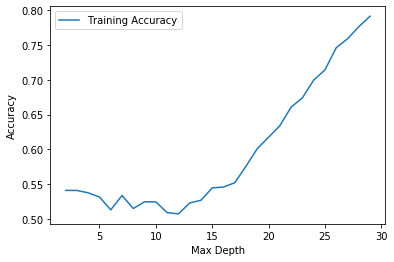

In [0]:
import matplotlib.pyplot as plt

plt.plot(max_depth_RF, train_acc_RF)
plt.legend(['Training Accuracy'])
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")

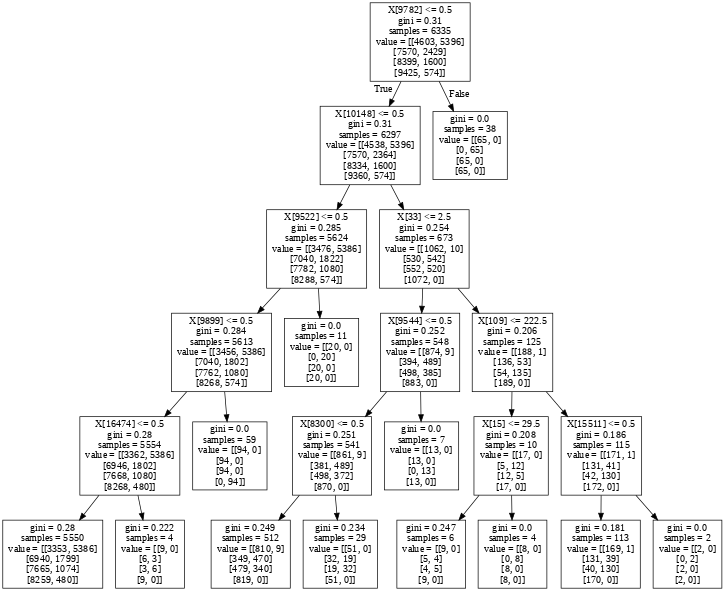

In [0]:
RF_clf = RandomForestClassifier(n_estimators=100, max_depth=5)
RF_clf= RF_clf.fit(dataVT, labelsVT)
predictVT = RF_clf.predict(dataVT)
train_acc_RF[i] = accuracy_score(labelsVT, predictVT)


estimator = RF_clf.estimators_[1]

from sklearn.tree import export_graphviz

export_graphviz(estimator, out_file='tree.dot' )

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png','-Gdpi=50'])

from IPython.display import Image
Image(filename = 'tree.png')


###